In [1]:
import nltk
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
#nltk.download('brown')

In [3]:
tagged_sent = nltk.corpus.brown.tagged_sents()

In [4]:
data_set=[]
for sentence in tagged_sent :
    words=[]
    tags=[]
    words = [w[0] for w in sentence]
    tags = [w[1] for w in sentence]
    data_set.append((words,tags))
data_set=data_set[:1000]

In [5]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)

word_to_ix = {}
tag_dic ={}
for sent, tags in data_set:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags :
        if tag not in tag_dic :
            tag_dic[tag] = len(tag_dic)
#print(word_to_ix)

EMBEDDING_DIM = 300
HIDDEN_DIM = 200

In [6]:
tag_dic

{"'": 89,
 "''": 11,
 '(': 65,
 '(-HL': 93,
 ')': 66,
 ')-HL': 94,
 '*': 61,
 ',': 17,
 ',-HL': 84,
 '--': 71,
 '.': 15,
 ':': 64,
 'ABL': 103,
 'ABN': 53,
 'ABX': 41,
 'AP': 33,
 'AP-HL': 109,
 'AP-TL': 131,
 'AT': 0,
 'AT-HL': 75,
 'AT-TL': 77,
 'BE': 47,
 'BE-HL': 139,
 'BED': 72,
 'BEDZ': 23,
 'BEDZ*': 83,
 'BEG': 74,
 'BEM': 122,
 'BEN': 26,
 'BER': 34,
 'BER-HL': 104,
 'BEZ': 50,
 'BEZ-HL': 133,
 'CC': 21,
 'CC-HL': 129,
 'CC-TL': 85,
 'CD': 45,
 'CD-HL': 100,
 'CD-TL': 91,
 'CS': 12,
 'CS-HL': 110,
 'DO': 57,
 'DO*': 135,
 'DOD': 32,
 'DOD*': 82,
 'DOZ': 79,
 'DOZ*': 140,
 'DT': 30,
 'DT$': 111,
 'DT-HL': 138,
 'DTI': 13,
 'DTS': 36,
 'DTX': 120,
 'EX': 62,
 'FW-DT': 114,
 'FW-IN': 113,
 'FW-IN+NN': 144,
 'FW-NN': 118,
 'HV': 35,
 'HVD': 19,
 'HVG': 119,
 'HVN': 112,
 'HVZ': 52,
 'IN': 7,
 'IN-HL': 97,
 'IN-TL': 22,
 'JJ': 9,
 'JJ-HL': 98,
 'JJ-TL': 3,
 'JJR': 48,
 'JJR-HL': 142,
 'JJS': 69,
 'JJS-TL': 102,
 'JJT': 40,
 'JJT-HL': 146,
 'MD': 46,
 'MD*': 86,
 'MD*-HL': 108,
 'MD-

In [7]:
class LSTMTagger(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return(autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
              autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))
    
    def forward(self, sentence):
        embeds = self.word_embedding(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return(tag_scores)

In [8]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_dic))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

inputs = prepare_sequence(data_set[0][0], word_to_ix)
tag_scores = model(inputs)
l=[]
for epoch in range(10): 
    for sentence, tags in data_set:
        #clear the gradient before each instance
        model.zero_grad()
        #clear out the hidden state of the lstm
        #detaching it from its history on the last instance
        model.hidden = model.init_hidden()
        
        #get the inputs ready for the network : turn them into variable os word indices
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_dic)
        
        #forward pass
        tag_scores = model(sentence_in)
        
        #compute the loss, gradient, and update the parameters 
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        l.append(loss)
        
inputs = prepare_sequence(data_set[0][0], word_to_ix)
tag_scores = model(inputs)


In [9]:
import numpy as np
lo = np.array(l).flatten()

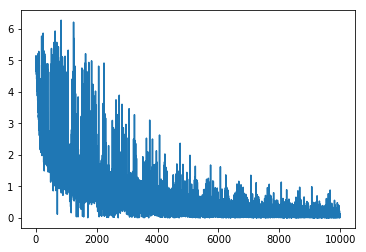

In [10]:
plt.plot(lo)